# Two-stage model

In [1]:
import evolutionary_functions as ev

import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.integrate as it
from scipy.stats import kde
import pandas as pd
from scipy.special import gamma
from IPython.display import clear_output
import scipy.optimize as opt
import os
import datetime

# plotting defaults
import matplotlib
matplotlib.rc_file_defaults()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Lato'


## Two-stage model for CH hotspots

Import hotspot cohort ages

In [2]:
# number of quantiles for plotting: choose 3 or 4
number_of_quantiles = 4

# import age distribution and quantile labels
biobank_bins_quantiles = pd.read_csv('inputs_participants/biobank_bins_quantiles.tsv', sep='\t').rename(
    columns={f'quantile_labels_{number_of_quantiles}': 'quantile_labels'})[
    ['Age.when.attended.assessment.centre_v0', 'age_count', 'quantile_labels']]
number_of_individuals = biobank_bins_quantiles.age_count.sum()

In [3]:
trimming_thresholds = {'DNMT3A R882H':0.03603267304887714,
                       'DNMT3A R882C':0.03641125564466615,
                       'DNMT3A Y735C': 0.02, #0.031021452650779963,
                       'DNMT3A P904L': 0.03050625833173621,
                       'DNMT3A R736H': 0.03875482257879603,
                       'DNMT3A R771*': 0.03427038103403027,
                       'DNMT3A R736C': 0.02691079729604606,
                       'DNMT3A R326C': 0.028204184173756756,
                       'DNMT3A R598*': 0.03076131339432306,
                       'DNMT3A R729W': 0.03783540677226178,
                       'GNB1 K57E': 0.14153654536164767,
                       'DNMT3A R320*': 0.028631527128345668,
                       'SRSF2 P95H': 0.04347979091423723,
                       'JAK2 V617F': 0.13520099097390018,
                       'SF3B1 K700E': 0.04598031864820239,
                       'SRSF2 P95R': 0.02953317476037705,
                       'SRSF2 P95L': 0.043065694094422076,
                       'DNMT3A R882S': 0.03679934975977073,
                       'IDH2 R140Q': 0.06330736020657143,
                       'SF3B1 K666N': 0.06919892423070759}

In [12]:
ukb_variants = pd.read_csv('inputs_variants/ukb_variants_trimmed_WIP.tsv', sep='\t')

# attach age quantile data
ukb_variants_quantiles = pd.merge(ukb_variants, biobank_bins_quantiles[['Age.when.attended.assessment.centre_v0', f'quantile_labels']], on='Age.when.attended.assessment.centre_v0', how='left')

# create useful dictionary of variant dataframes
ukb_variants_dict = {}
for varid in ukb_variants_quantiles.varID.unique():
    ukb_variants_dict[varid] = ukb_variants_quantiles[ukb_variants_quantiles['varID'] == varid].reset_index(drop=True)

### Results

In [5]:
# import results
filename = 'results_files/ageing_optimisation_independent_trimmed_v4.tsv'
N = 100000
step_age = 40
opt_results = pd.read_csv(filename, sep='\t').reset_index(drop=True)

Calculate predicted densities

In [7]:
overall_density_dict = {}
quantile_density_dict = {}
for i, varid in enumerate(opt_results.varID[0:20]):
    clear_output()
    print(varid)
    variant_quantiles = ukb_variants_dict[varid]
    opt_row = opt_results[opt_results.varID == varid]
    mu, s1, s2 = [opt_row.mu.squeeze(), opt_row.s1.squeeze(), opt_row.s2.squeeze()]
    overall_density_dict[varid], quantile_density_dict[varid] = ev.ageing_predictions_calc(mu, s1, s2, N, step_age, variant_quantiles, biobank_bins_quantiles, number_of_quantiles)


DNMT3A R882H


Calculate prevalences

In [6]:
prevalences = {}
for i, varid in enumerate(opt_results.varID):
    #clear_output()
    #print(varid)
    opt_row = opt_results[opt_results.varID == varid]
    mu, s1, s2 = [opt_row.mu.squeeze(), opt_row.s1.squeeze(), opt_row.s2.squeeze()]
    variant_quantiles = ukb_variants_dict[varid]
    D = variant_quantiles.depth.mean()
    mu, s1, s2 = [opt_row.mu.squeeze(), opt_row.s1.squeeze(), opt_row.s2.squeeze()]
    prevalences[varid] = ev.estimate_prevalence(trimming_thresholds[varid], [mu, s1, s2, 40], N)

In [8]:
# redefine plot_prevalence for this notebook specifically
def plot_prevalence(axes, variants, biobank_bins_quantiles, bins_age, prev_ageing, colour, prev_naive=None, logscale=False):
    diffs = np.diff(bins_age)
    bin_centres = bins_age[:-1] + diffs / 2
    pheno_all_ages = np.repeat(biobank_bins_quantiles['Age.when.attended.assessment.centre_v0'].values,
                               biobank_bins_quantiles['age_count'].values).tolist()
    pheno_age_bins = np.histogram(pheno_all_ages, bins=bins_age)[0]
    variant_bins = np.histogram(variants['Age.when.attended.assessment.centre_v0'], bins=bins_age)[0]
    errors = np.sqrt(variant_bins)

    x1 = list(range(1, 41))
    x2 = list(range(40, 91))
    axes.plot(x1, prev_ageing[:len(x1)], ls='dashed', c=colour, alpha=0.3)
    axes.plot(x2, prev_ageing[len(x1):], c=colour, alpha=1)

    axes.scatter(bin_centres, variant_bins / pheno_age_bins, label='placeholder', c=colour)
    axes.errorbar(bin_centres, variant_bins / pheno_age_bins, errors / pheno_age_bins, ls='none', color=colour)
    if logscale:
        axes.set_yscale('log')
        axes.set_ylim(1e-5, 1e-4)
        #axes.set_ylim(variant_bins[0]/5)
    else:
        axes.set_ylim(0, variant_bins[-1] * 1.7 / pheno_age_bins[-1])
    #axes.legend(fontsize=12)
    axes.set_ylabel('prevalence')
    axes.set_xlabel('age')
    axes.set_xlim(20, 75)

    axes.axvspan(0, 40, alpha=0.1, facecolor='grey', edgecolor='None')
    #yticks = axes.get_yticks()
    #axes.set_yticks(yticks, labels=[str(f'{a*100:.2g}')+'%' for a in yticks]) # rounded to 2sf
    #axes.set_ylim(axes.get_ylim())

    if prev_naive is not None:
        x = list(range(0, 91))
        axes.plot(x, prev_naive, lw=0.5, c='k', alpha=0.3)

    axes.axvspan(0, 40, alpha=0.1, facecolor='grey', edgecolor='None')
    yticks = axes.get_yticks()
    axes.set_yticks(yticks, labels=[str(f'{a*100:.2g}')+'%' for a in yticks]) # rounded to 2sf


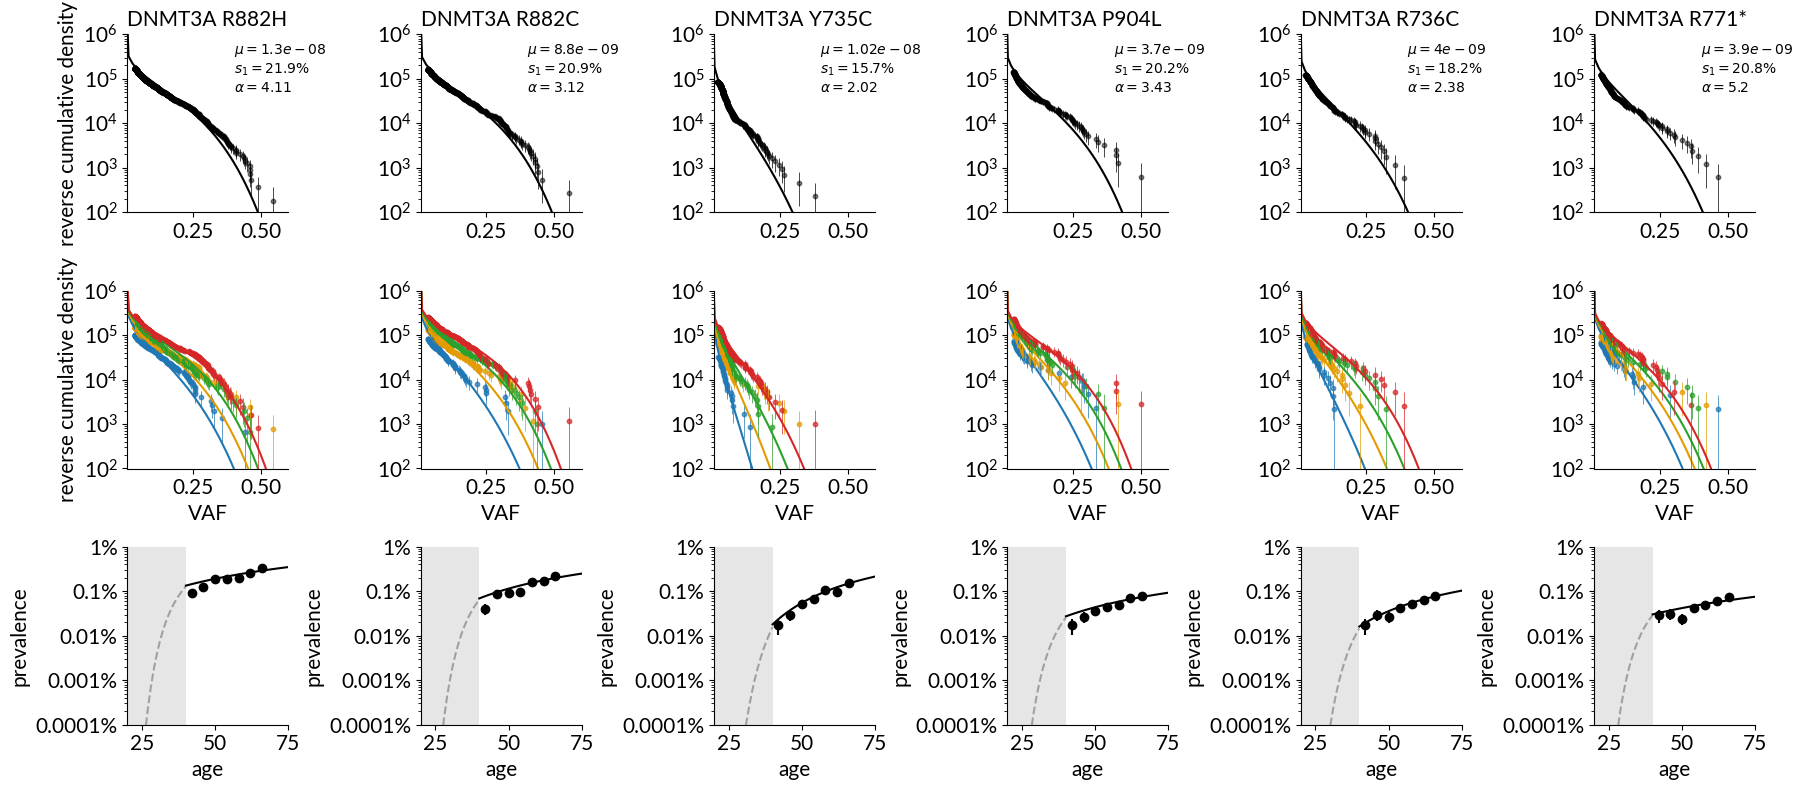

In [13]:
fig, ax = plt.subplots(3, 6, figsize=[18, 8])
col = 0
x = np.arange(0.0, 0.25, 0.005)
bins_age = np.arange(40, 70, 4)
quantile_colour_list = ['tab:blue', '#e39b00', 'tab:green', 'C3', 'C4']
for variant_name in opt_results.varID[::-1][0:6]:
    if variant_name in ['JAK2 V617F', 'GNB1 K57E']: continue
    variant_quantiles = ukb_variants_dict[variant_name]
    opt_row = opt_results[opt_results.varID == variant_name]
    mu, s1, s2 = [opt_row.mu.squeeze(), opt_row.s1.squeeze(), opt_row.s2.squeeze()]
    ev.overall_density_plot(ax[0, col], variant_quantiles, mu, overall_density_dict[variant_name], number_of_individuals, colour='k')
    ev.quantile_density_plot(ax[1, col], variant_quantiles, mu, quantile_density_dict[variant_name], number_of_quantiles, quantile_colour_list, biobank_bins_quantiles, errorbars=True)
    ax[0, col].set_title(variant_name, fontsize=15, loc='left')
    ax[1, col].set_xlabel('VAF')
    ax[0, col].text(0.4, 0.5e5, fr'$\mu = {np.round(mu, 10)}$'+'\n'+fr'$s_1 = {np.round(s1*100, 1)}\%$'+'\n'+fr'$\alpha = {np.round(s1/s2, 2)}$')


    for row in range(2):
        ax[row, col].set_yscale('log')
        #ax[row, col].set_xscale('log')
        ax[row, col].set_ylim(1e2, 1e6)
        ax[row, col].set_xlim(0.01, 0.6)
        ax[row, 0].set_ylabel('reverse cumulative density')
        ax[row, col].grid(False)
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)

    plot_prevalence(ax[2, col], variant_quantiles, biobank_bins_quantiles, bins_age, prevalences[variant_name], colour='k', prev_naive=None, logscale=True)

    col += 1


plt.tight_layout()
plt.show()

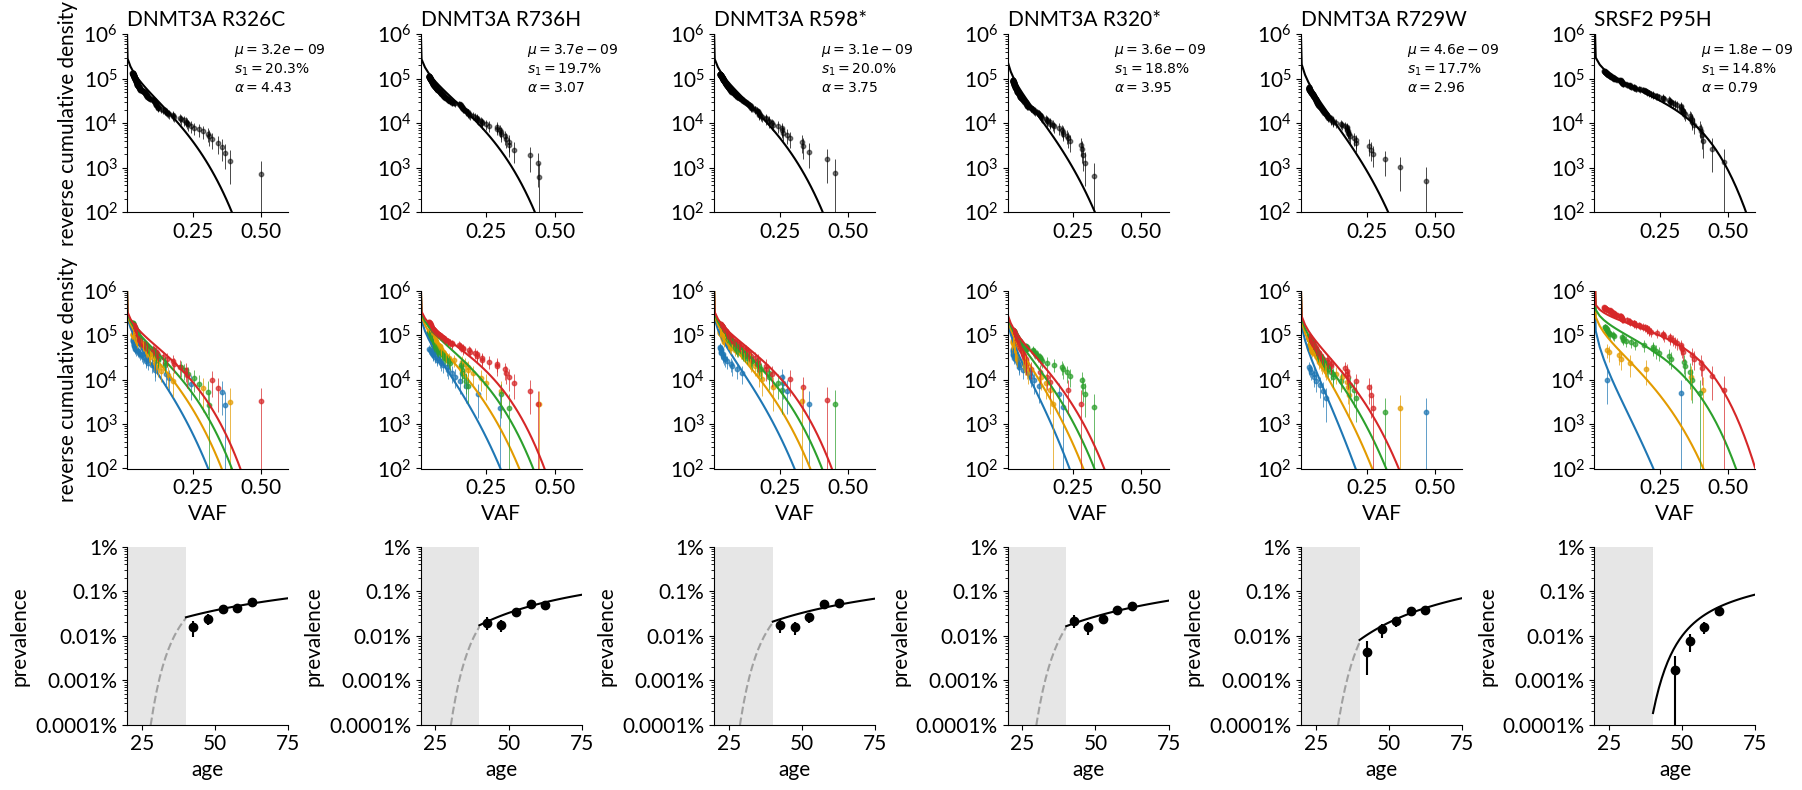

In [15]:
fig, ax = plt.subplots(3, 6, figsize=[18, 8])
col = 0
x = np.arange(0.0, 0.25, 0.005)
bins_age = np.arange(40, 70, 5)
quantile_colour_list = ['tab:blue', '#e39b00', 'tab:green', 'C3', 'C4']
for variant_name in opt_results.varID[::-1][6:12]:
    if variant_name in ['JAK2 V617F', 'GNB1 K57E']: continue
    variant_quantiles = ukb_variants_dict[variant_name]
    opt_row = opt_results[opt_results.varID == variant_name]
    mu, s1, s2 = [opt_row.mu.squeeze(), opt_row.s1.squeeze(), opt_row.s2.squeeze()]
    ev.overall_density_plot(ax[0, col], variant_quantiles, mu, overall_density_dict[variant_name], number_of_individuals, colour='k')
    ev.quantile_density_plot(ax[1, col], variant_quantiles, mu, quantile_density_dict[variant_name], number_of_quantiles, quantile_colour_list, biobank_bins_quantiles, errorbars=True)
    ax[0, col].set_title(variant_name, fontsize=15, loc='left')
    ax[1, col].set_xlabel('VAF')
    ax[0, col].text(0.4, 0.5e5, fr'$\mu = {np.round(mu, 10)}$'+'\n'+fr'$s_1 = {np.round(s1*100, 1)}\%$'+'\n'+fr'$\alpha = {np.round(s1/s2, 2)}$')


    for row in range(2):
        ax[row, col].set_yscale('log')
        #ax[row, col].set_xscale('log')
        ax[row, col].set_ylim(1e2, 1e6)
        ax[row, col].set_xlim(0.01, 0.6)
        ax[row, 0].set_ylabel('reverse cumulative density')
        ax[row, col].grid(False)
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)

    plot_prevalence(ax[2, col], variant_quantiles, biobank_bins_quantiles, bins_age, prevalences[variant_name], colour='k', prev_naive=None, logscale=True)

    col += 1


plt.tight_layout()
plt.show()

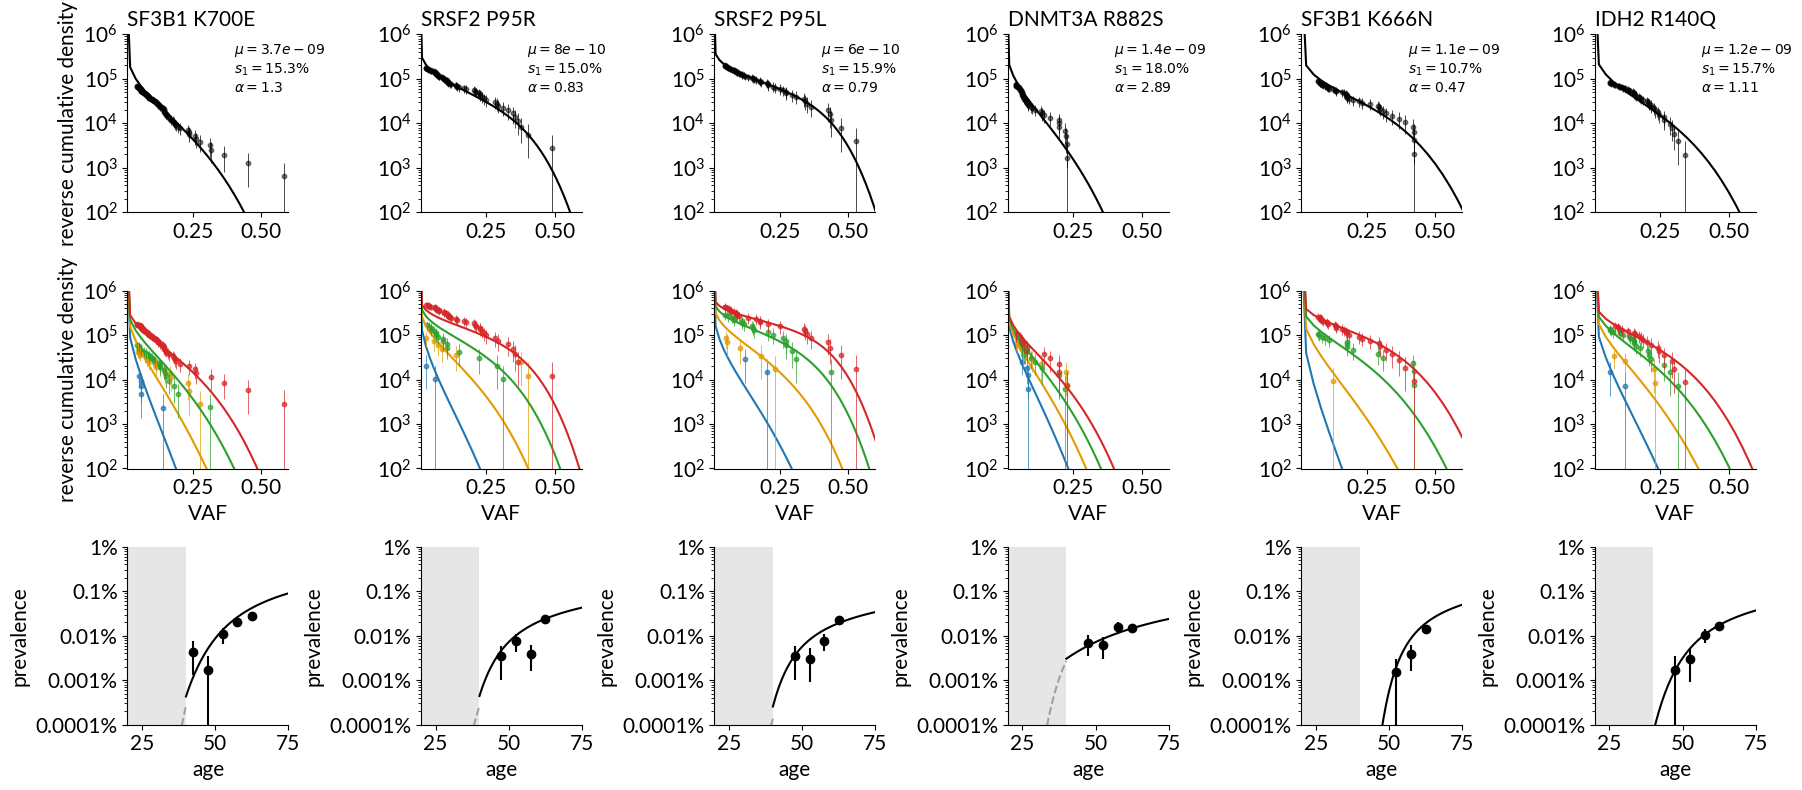

In [16]:
fig, ax = plt.subplots(3, 6, figsize=[18, 8])
col = 0
x = np.arange(0.0, 0.25, 0.005)
bins_age = np.arange(40, 70, 5)
quantile_colour_list = ['tab:blue', '#e39b00', 'tab:green', 'C3', 'C4']
for variant_name in opt_results.varID[::-1][12:18]:
    if variant_name in ['JAK2 V617F', 'GNB1 K57E']: continue
    variant_quantiles = ukb_variants_dict[variant_name]
    opt_row = opt_results[opt_results.varID == variant_name]
    mu, s1, s2 = [opt_row.mu.squeeze(), opt_row.s1.squeeze(), opt_row.s2.squeeze()]
    ev.overall_density_plot(ax[0, col], variant_quantiles, mu, overall_density_dict[variant_name], number_of_individuals, colour='k')
    ev.quantile_density_plot(ax[1, col], variant_quantiles, mu, quantile_density_dict[variant_name], number_of_quantiles, quantile_colour_list, biobank_bins_quantiles, errorbars=True)
    ax[0, col].set_title(variant_name, fontsize=15, loc='left')
    ax[1, col].set_xlabel('VAF')
    ax[0, col].text(0.4, 0.5e5, fr'$\mu = {np.round(mu, 10)}$'+'\n'+fr'$s_1 = {np.round(s1*100, 1)}\%$'+'\n'+fr'$\alpha = {np.round(s1/s2, 2)}$')


    for row in range(2):
        ax[row, col].set_yscale('log')
        #ax[row, col].set_xscale('log')
        ax[row, col].set_ylim(1e2, 1e6)
        ax[row, col].set_xlim(0.01, 0.6)
        ax[row, 0].set_ylabel('reverse cumulative density')
        ax[row, col].grid(False)
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)

    plot_prevalence(ax[2, col], variant_quantiles, biobank_bins_quantiles, bins_age, prevalences[variant_name], colour='k', prev_naive=None, logscale=True)

    col += 1


plt.tight_layout()
plt.show()

## Exome-wide calls

Colours for plotting

In [24]:
# genes that pass the filters
genes_pass = ['DNMT3A', 'TET2', 'ASXL1', 'TP53', 'PPM1D', 'SF3B1', 'U2AF1', 'GNB1', 'SRSF2', 'CBL', 'ATM', 'YLPM1', 'ZBTB33', 'MYD88', 'ZNF318', 'JAK2', 'GNAS', 'IDH2']

# List of genes

# Define contrasting colors
darker_colors = [
    '#C0392B',  # Dark Red
    '#27AE60',  # Dark Green
    '#2980B9',  # Dark Blue
    '#C71585',  # Dark Magenta
    '#16A085',  # Dark Cyan
    '#F39C12',  # Dark Yellow
    '#8E44AD',  # Dark Purple
    '#D35400',  # Dark Orange
    '#1ABC9C',  # Dark Teal
    '#A3C940',  # Dark Lime
    '#D5006D',  # Dark Pink
    '#6A5ACD',  # Dark Violet
    '#E67E22',  # Dark Coral
    'grey',
    'brown',
    'pink',
    'black',
    'purple'
]

# Create a dictionary mapping genes to colors
gene_colour_dict = {gene: darker_colors[i] for i, gene in enumerate(genes_pass)}

Exome-wide cohort ages

In [25]:
# number of quantiles for plotting: choose 3 or 4
number_of_quantiles = 4

# import age distribution and quantile labels
biobank_bins_quantiles = pd.read_csv('inputs_participants/biobank_bins_quantiles_exome_cohort.tsv', sep='\t').rename(
    columns={f'quantile_labels_{number_of_quantiles}': 'quantile_labels'})[
    ['Age.when.attended.assessment.centre_v0', 'age_count', 'quantile_labels']]
number_of_individuals = biobank_bins_quantiles.age_count.sum()

Exome-wide CH calls

In [26]:
# import variants
bolton_ch = pd.read_csv('inputs_variants/bolton_ch_healthy_curated.tsv', sep='\t')

# attach quantile labels
bolton_ch = pd.merge(bolton_ch, biobank_bins_quantiles[['Age.when.attended.assessment.centre_v0', 'quantile_labels']], on='Age.when.attended.assessment.centre_v0', how='left')
bolton_ch = bolton_ch.rename(columns={'sample_ID':'ID_v0'})

# organise into a dict gene-by-gene
bolton_ch_dict = {}
for gene in bolton_ch.gene.value_counts().index: # so that the dict keys come out in prevalence order
    if (gene in genes_pass) & (gene != 'IDH2'):
        bolton_ch_dict[gene] = bolton_ch[bolton_ch.gene == gene].reset_index(drop=True)

In [27]:
# trimming
bolton_trimming_thresholds = {'DNMT3A': 0.04,
                              'TET2':0.04, 
                              'ASXL1':0.03409090909090909,
                              'TP53':0.047619047619047616,
                              'PPM1D':0.03896103896103896,
                              'SF3B1':0.058823529411764705,
                              'U2AF1':0.034482758620689655,
                              'GNB1':0.10714285714285714,
                              'SRSF2':0.037037037037037035,
                              'CBL':0.06, 
                              'ATM':0.04,
                              'YLPM1':0.0410958904109589,
                              'ZBTB33':0.05,
                              'MYD88':0.041666666666666664,
                              'ZNF318': 0.04225352112676056,
                              'JAK2':0.1111111111111111,
                              'GNAS':0.07142857142857142}

In [28]:
# Trim according to manually adjusted thresholds
bolton_ch_dict_trimmed = {}
for gene in bolton_ch_dict.keys():
    variants = bolton_ch_dict[gene]
    #D = int(variants.depth.mean())
    variants_trimmed = variants[variants.VAF >= bolton_trimming_thresholds[gene]].reset_index(drop=True)
    bolton_ch_dict_trimmed[gene] = variants_trimmed

### Figure 2: number of variants in each gene

Figure 2

In [30]:


bolton_final_genes_trimmed = {}
bolton_all_final_genes_trimmed = pd.DataFrame()
for gene in genes_pass:
    if gene in ['CBL', 'JAK2', 'GNB1', 'IDH2']: continue
    bolton_final_genes_trimmed[gene] = bolton_ch_dict_trimmed[gene]
    bolton_all_final_genes_trimmed = pd.concat([bolton_all_final_genes_trimmed, bolton_ch_dict_trimmed[gene]], axis=0)


bolton_ids_dict_trimmed = {}
for gene in bolton_all_final_genes_trimmed.gene.value_counts().index: #so that the dict keys come out in prevalence order
    bolton_ids_dict_trimmed[gene] = bolton_all_final_genes_trimmed[bolton_all_final_genes_trimmed.gene == gene].reset_index(drop=True)['varID']

value_count_dict_trimmed = {}
for gene in bolton_all_final_genes_trimmed.gene.value_counts().index:
    df = bolton_ids_dict_trimmed[gene]
    count_series = df.value_counts()[:6]
    count_series['other'] = df.value_counts()[6:].sum()
    if (sum(count_series) > 1):  # & (len(count_series) == 7):
        value_count_dict_trimmed[gene] = count_series
counts = pd.DataFrame(value_count_dict_trimmed).fillna(0)
proportions = counts.div(counts.sum(axis=0), axis=1)

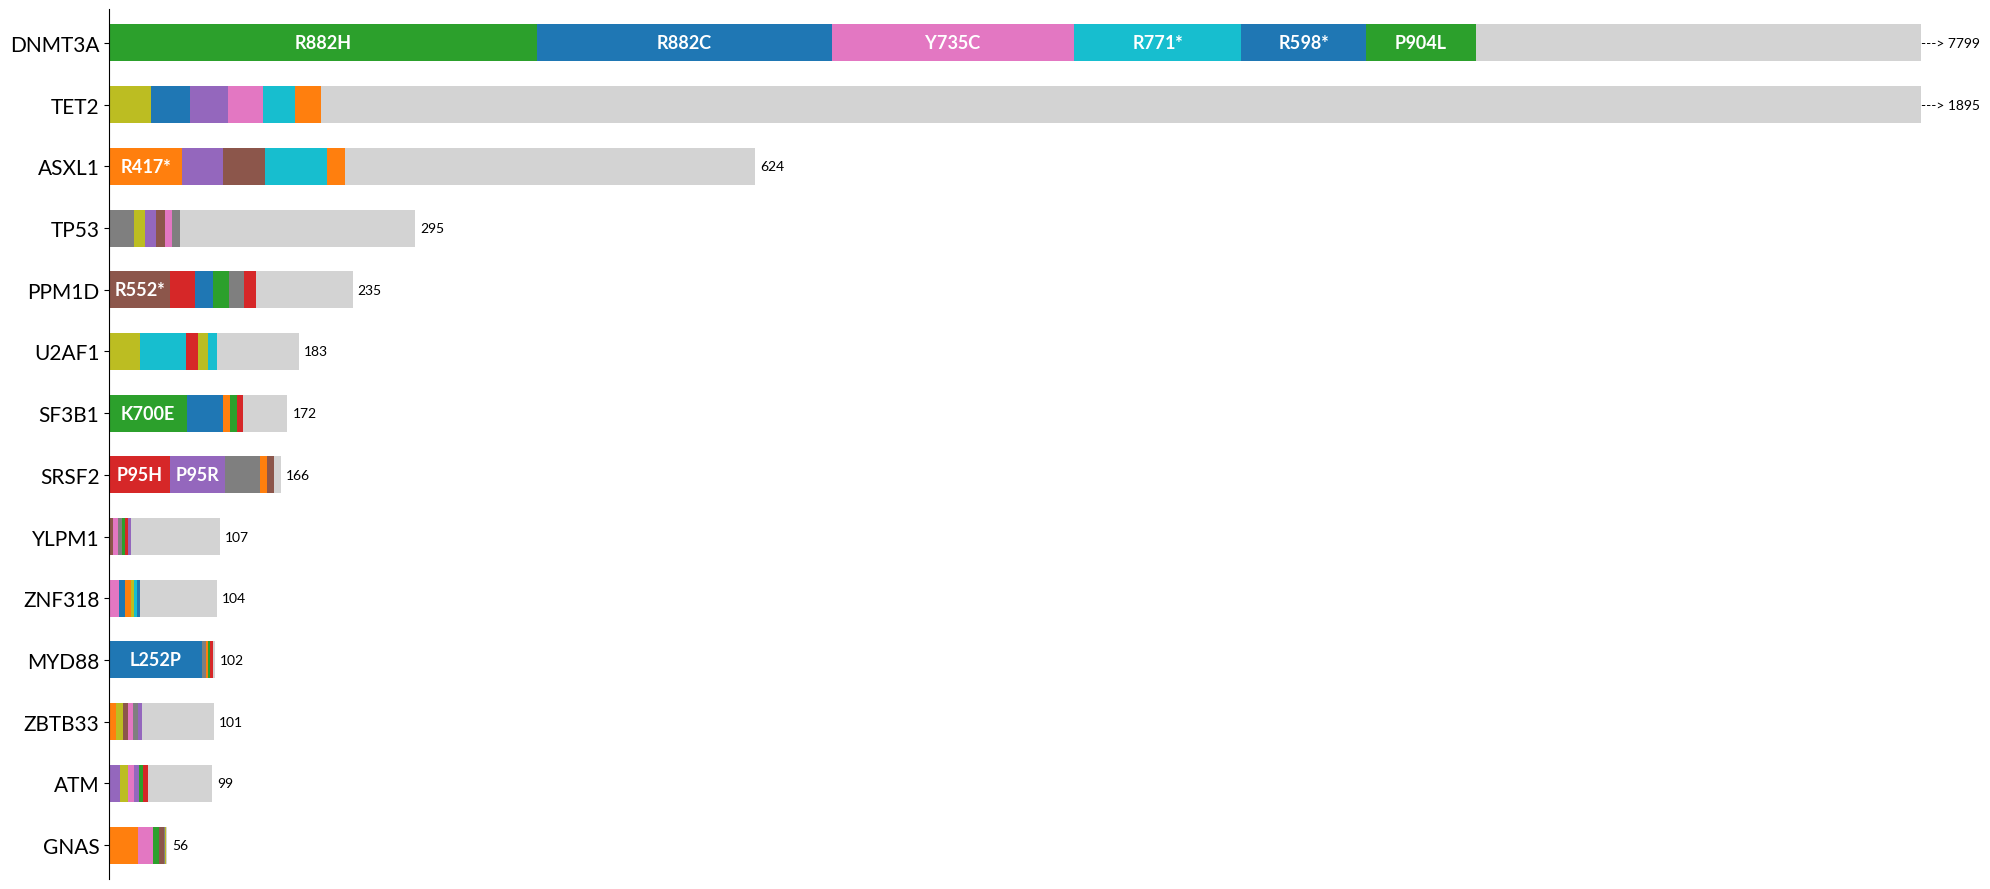

In [32]:
# Plotting
fig, ax = plt.subplots(figsize=(20, 9))

# Stack the bars
columns_order = list(proportions.T.sum(axis=0).sort_values(ascending=False).index[1:])+['other']
counts_t = counts.T[columns_order]
proportions_t = proportions.T[columns_order]
bars = counts_t.plot(kind='barh', stacked=True, ax=ax, width=0.6)
ax.get_legend().remove()
ax.invert_yaxis()
ax.set_xlim(0, 1750)

#labels
var_index = 0
for container in bars.containers:
    for i, bar in enumerate(container):
        var_name = proportions_t.columns[var_index]
        #print(i, bar)
        width=bar.get_width()
        if var_name == 'other':
            bar.set_color('lightgrey')
            bar.set_edgecolor('none')
            continue
        elif width >= 50:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + bar.get_height()/2,
                f'{var_name.split(" ")[1]}', ha='center', va='center', color='white', fontsize=13, fontweight='bold'
            )
    var_index += 1

for i, gene in enumerate(value_count_dict_trimmed.keys()):
    label_position = sum(value_count_dict_trimmed[gene])
    label_value = label_position
    if label_position > 1750:
        label_position = 1750
        label_value = '---> '+str(label_value)
    else:
        label_position += 5
    ax.text(label_position, i, label_value, ha='left', va='center')
ax.get_xaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

Summary plot for all variants

In [33]:
genes_to_plot = ['DNMT3A', 'TET2', 'ASXL1', 'TP53', 'PPM1D', 'U2AF1', 'SF3B1', 'SRSF2', 'YLPM1', 'ZNF318', 'MYD88', 'ZBTB33', 'ATM', 'GNAS', 'IDH2']


In [34]:
# define which plotting approach to take with each gene
gene_approach = {}
for gene in list(genes_pass):
    gene_approach[gene] = ['gene', 'gene_CI', 'hotspots']
    
for gene in ['SF3B1', 'MYD88', 'IDH2']: # ['JAK2', 'GNB1']
    gene_approach[gene] = ['hotspots']
    
for gene in ['DNMT3A']: # ['CBL']
    gene_approach[gene] = ['gene', 'hotspots']

In [35]:
# create groups by gene:
hotspot_filename = 'results_files/ageing_optimisation_independent_trimmed_v4.tsv'
hotspot_results = pd.read_csv(hotspot_filename, sep='\t')[::-1].reset_index(drop=True)

gene_groups = {}
for varid in hotspot_results.varID:
    gene = varid.split(' ')[0]
    if gene in gene_groups.keys():
        gene_groups[gene].append(varid)
    else:
        gene_groups[gene] = [varid]

In [38]:
# bolton hotspot groups - # Need to re-do these
bolton_hotspot_filename = 'results_files/bolton_ageing_hotspots_optimisation_final_v1.tsv'
bolton_hotspots_results = pd.read_csv(bolton_hotspot_filename, sep='\t').sort_values('n_variants', ascending=False).reset_index(drop=True)

bolton_hotspots_groups = {}
for varid in bolton_hotspots_results.varID[::-1]:
    gene = varid.split(' ')[0]
    if gene in bolton_hotspots_groups.keys():
        bolton_hotspots_groups[gene].append(varid)
    else:
        bolton_hotspots_groups[gene] = [varid]

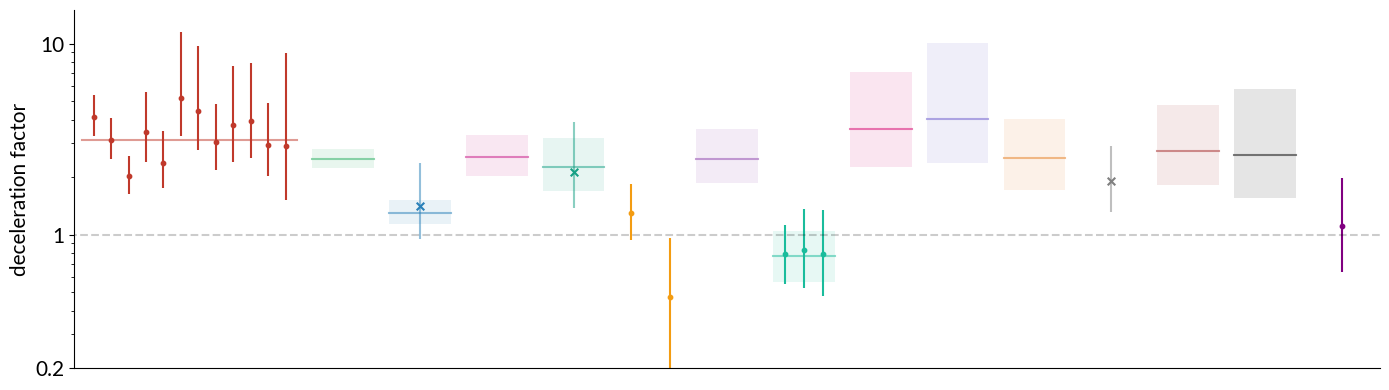

In [41]:
# with text instead of tick labels
fig, ax = plt.subplots(1, 1, figsize=[14, 4])

hotspot_filename = 'results_files/ageing_optimisation_independent_trimmed_v4.tsv'
hotspot_results = pd.read_csv(hotspot_filename, sep='\t')
hotspot_ci = np.load('results_files/hotspot_optimised_confidence_intervals_95_chisq_method.npy', allow_pickle=True).item()

gene_wide_filename = 'results_files/bolton_ageing_optimisation_final_v1.tsv'
gene_wide_results = pd.read_csv(gene_wide_filename, sep='\t')
gene_wide_ci = np.load('results_files/bolton_ageing_optimised_CI_chisq_method.npy', allow_pickle=True).item()

bolton_hotspot_filename = 'results_files/bolton_ageing_hotspots_optimisation_final_v1.tsv'
bolton_hotspots_results = pd.read_csv(bolton_hotspot_filename, sep='\t')
bolton_hotspots_ci = np.load('results_files/bolton_ageing_hotspots_optimised_CI_chisq_method.npy', allow_pickle=True).item()

# start by plotting the existing results (gene-level)
x = 2.5 # position tracker
x0 = 0.5 # initial position tracker
i = 0 # counter
x_tick_positions = []
genes_used = []
for gene in genes_pass:
    if gene in ['CBL', 'JAK2', 'GNB1']: continue

    opt_row = gene_wide_results[gene_wide_results.gene == gene]
    mu, s1, s2 = [opt_row.mu.squeeze(), opt_row.s1.squeeze(), opt_row.s2.squeeze()]
    alpha = s1/s2

    # need to do position for all genes, regardless of whether we are plotting teh gene-wide stuff or not

    #ax.text(x, 12, gene, color=gene_colour_dict[gene], ha='center', size=15)
    #ax.vlines([x0, x], 0.5, 5) #shows position of x0 and x for reference

    if 'gene' in gene_approach[gene]:
        ax.plot([x0-0.4, x+0.4], [alpha, alpha], color=gene_colour_dict[gene], alpha=0.5)
        if 'gene_CI' in gene_approach[gene]:
            lower_conf, upper_conf = gene_wide_ci[gene]
            #ax.hlines([lower_conf, upper_conf], x0-0.4, x+0.4, color='k', alpha=0.2, ls='dotted')
            ax.fill_between([x0-0.4, x0+0.4], [lower_conf, lower_conf], [upper_conf, upper_conf], facecolor=gene_colour_dict[gene], edgecolor='none', alpha=0.1)

    if 'hotspots' in gene_approach[gene]:

        # genes with hajm2 hotspots:
        if gene in gene_groups.keys():
            # hajm2 hotspots
            hotspots_in_gene = gene_groups[gene].copy() # needs copy() otherwise (for some reason) appending to this list also appends to the original dictionary!!
            hajm2_hotspots = gene_groups[gene].copy() # hajm2 hotspots only
        else:
            hotspots_in_gene = []
            hajm2_hotspots = []

        # add bolton hotspots, except to DNMT3A

        if gene != 'DNMT3A':
            if gene in bolton_hotspots_groups.keys():
                for varid in bolton_hotspots_groups[gene]:
                    if varid not in hotspots_in_gene: hotspots_in_gene.append(varid)
            remaining_hotspots = [varid for varid in hotspots_in_gene if varid not in hajm2_hotspots]
        else:
            remaining_hotspots = []


        if len(hotspots_in_gene) > 0:
            # plot hajm2 hotspots
            conf_ints = []
            hotspot_y = []
            if len(hotspots_in_gene) == 1: hotspot_x = [0.5*(x0+x)]
            else: hotspot_x = np.linspace(x0-0.25, x+0.25, len(hotspots_in_gene))

            # hajm2 hotspots

            if len(hajm2_hotspots) > 0:
                for m, varid in enumerate(hajm2_hotspots):
                    opt_hotspot_row = hotspot_results[hotspot_results.varID == varid]
                    mu_opt, s1_opt, s2_opt = [opt_hotspot_row.mu.squeeze(), opt_hotspot_row.s1.squeeze(), opt_hotspot_row.s2.squeeze()]
                    alpha_opt = s1_opt/s2_opt
                    hotspot_y.append(alpha_opt)

                    if varid in hotspot_ci.keys():
                        relative_conf = (alpha_opt - hotspot_ci[varid][0], hotspot_ci[varid][1] - alpha_opt)
                        conf_ints.append(relative_conf)
                    else:
                        conf_ints.append((np.nan, np.nan))



                hotspot_x_hajm2 = hotspot_x[:len(hajm2_hotspots)]
                ax.scatter(hotspot_x_hajm2, hotspot_y, marker='o', color=gene_colour_dict[gene], s=10)
                ax.errorbar(hotspot_x_hajm2, hotspot_y, np.array(conf_ints).T, ls='none', color=gene_colour_dict[gene], capsize=0)

            if len(remaining_hotspots) > 0: # non-hajm2 hotspots
                conf_ints = []
                hotspot_y = []
                for m, varid in enumerate(remaining_hotspots):
                    opt_hotspot_row = bolton_hotspots_results[bolton_hotspots_results.varID == varid]
                    mu_opt, s1_opt, s2_opt = [opt_hotspot_row.mu.squeeze(), opt_hotspot_row.s1.squeeze(), opt_hotspot_row.s2.squeeze()]
                    alpha_opt = s1_opt/s2_opt
                    hotspot_y.append(alpha_opt)

                    if varid in bolton_hotspots_ci.keys():
                        relative_conf = (alpha_opt - bolton_hotspots_ci[varid][0], bolton_hotspots_ci[varid][1] - alpha_opt)
                        conf_ints.append(relative_conf)
                    else:
                        conf_ints.append((np.nan, np.nan))

                hotspot_x_remaining = hotspot_x[len(hajm2_hotspots):]
                ax.scatter(hotspot_x_remaining, hotspot_y, marker='x', s=30, color=gene_colour_dict[gene]) #facecolor='white', edgecolor=gene_colour_dict[gene], s=50)
                ax.errorbar(hotspot_x_remaining, hotspot_y, np.array(conf_ints).T, ls='none', color=gene_colour_dict[gene], capsize=0, alpha=0.5)


    x += 1 # updated x
    i += 1 # update counter
    x0 = x # update x0



# extranea
ax.hlines(1, -0.5, x-0.5, ls='dashed', color='k', alpha=0.2)
ax.set_xticks([])
#ax.spines['right'].set_visible(True)
#ax.spines['top'].set_visible(True)
#ax.set_xticks(x_tick_positions, genes_used)
#ax.tick_params('x', labelsize=10, rotation=45)


# formatting
#ax.text(0, 1.2, 'decelerating', alpha=0.4, va='center', size=12)
#ax.text(0, 1/1.2, 'accelerating', alpha=0.4, va='center', size=12)
#ax.arrow(-0.2, 1.04, 0, 1.4-1, head_width=0.2, head_length=0.1, length_includes_head=True, overhang=1, alpha=0.4)
#ax.arrow(-0.2, 0.96, 0, 1/1.4 - 1, head_width=0.2, head_length=0.05, length_includes_head=True, overhang=1, alpha=0.4)

ax.set_yscale('log')
ax.set_xlim(0, len(genes_to_plot)+2)
ax.set_yticks([0.2, 1, 10])
ax.set_yticklabels([0.2, 1, 10])
ax.set_ylim(0.2, 15)
ax.set_ylabel('deceleration factor', size=15)
plt.tight_layout()
plt.show()

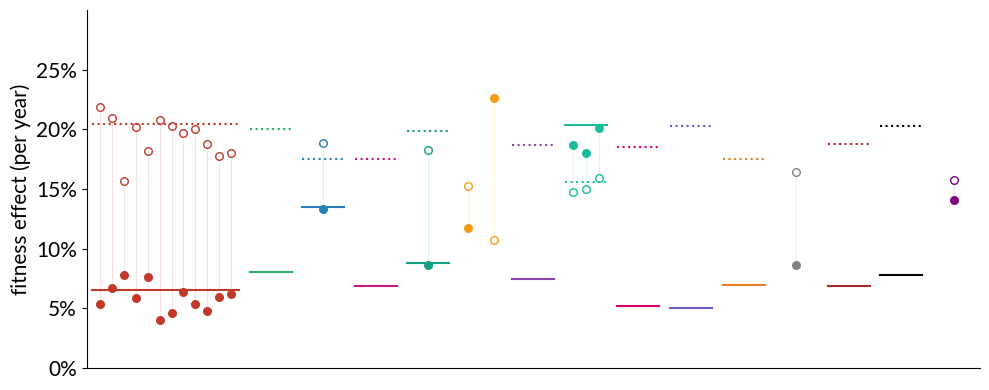

In [42]:
# with text instead of tick labels
fig, ax = plt.subplots(1, 1, figsize=[10, 4])

hotspot_filename = 'results_files/ageing_optimisation_independent_trimmed_v4.tsv'
hotspot_results = pd.read_csv(hotspot_filename, sep='\t')
hotspot_ci = np.load('results_files/hotspot_optimised_confidence_intervals_95_chisq_method.npy', allow_pickle=True).item()

gene_wide_filename = 'results_files/bolton_ageing_optimisation_final_v1.tsv'
gene_wide_results = pd.read_csv(gene_wide_filename, sep='\t')
gene_wide_ci = np.load('results_files/bolton_ageing_optimised_CI_chisq_method.npy', allow_pickle=True).item()

bolton_hotspot_filename = 'results_files/bolton_ageing_hotspots_optimisation_final_v1.tsv'
bolton_hotspots_results = pd.read_csv(bolton_hotspot_filename, sep='\t')
bolton_hotspots_ci = np.load('results_files/bolton_ageing_hotspots_optimised_CI_chisq_method.npy', allow_pickle=True).item()

# start by plotting the existing results (gene-level)
x = 2.5 # position tracker
x0 = 0.5 # initial position tracker
i = 0 # counter
x_tick_positions = []
genes_used = []
for gene in genes_pass:
    if gene in ['CBL', 'JAK2', 'GNB1']: continue

    opt_row = gene_wide_results[gene_wide_results.gene == gene]
    mu, s1, s2 = [opt_row.mu.squeeze(), opt_row.s1.squeeze(), opt_row.s2.squeeze()]
    alpha = s1/s2

    # need to do position for all genes, regardless of whether we are plotting teh gene-wide stuff or not

    #####ax.text(x, 0.25, gene, color=gene_colour_dict[gene], ha='center', size=12)
    #ax.vlines([x0, x], 0.5, 5) #shows position of x0 and x for reference

    if 'gene' in gene_approach[gene]:

        ax.plot([x0-0.4, x+0.4], [s1, s1], color=gene_colour_dict[gene], ls='dotted')
        ax.plot([x0-0.4, x+0.4], [s2, s2], color=gene_colour_dict[gene])

    if 'hotspots' in gene_approach[gene]:

        # genes with hajm2 hotspots:
        if gene in gene_groups.keys():
            # hajm2 hotspots
            hotspots_in_gene = gene_groups[gene].copy() # needs copy() otherwise (for some reason) appending to this list also appends to the original dictionary!!
            hajm2_hotspots = gene_groups[gene].copy() # hajm2 hotspots only
        else:
            hotspots_in_gene = []
            hajm2_hotspots = []

        # add bolton hotspots
        if gene != 'DNMT3A':
            if gene in bolton_hotspots_groups.keys():
                for varid in bolton_hotspots_groups[gene]:
                    if varid not in hotspots_in_gene: hotspots_in_gene.append(varid)
            remaining_hotspots = [varid for varid in hotspots_in_gene if varid not in hajm2_hotspots]
        else:
            remaining_hotspots = []


        if len(hotspots_in_gene) > 0:
            # plot hajm2 hotspots
            conf_ints = []
            hotspot_s1 = []
            hotspot_s2 = []
            if len(hotspots_in_gene) == 1: hotspot_x = [0.5*(x0+x)]
            else: hotspot_x = np.linspace(x0-0.25, x+0.25, len(hotspots_in_gene))

            # hajm2 hotspots

            if len(hajm2_hotspots) > 0:
                for m, varid in enumerate(hajm2_hotspots):
                    opt_hotspot_row = hotspot_results[hotspot_results.varID == varid]
                    mu_opt, s1_opt, s2_opt = [opt_hotspot_row.mu.squeeze(), opt_hotspot_row.s1.squeeze(), opt_hotspot_row.s2.squeeze()]
                    hotspot_s1.append(s1_opt)
                    hotspot_s2.append(s2_opt)

                hotspot_x_hajm2 = hotspot_x[:len(hajm2_hotspots)]
                ax.scatter(hotspot_x_hajm2, hotspot_s1, marker='o', edgecolor=gene_colour_dict[gene], facecolor='white', s=30)
                ax.scatter(hotspot_x_hajm2, hotspot_s2, marker='o', color=gene_colour_dict[gene], s=30)
                ax.vlines(hotspot_x_hajm2, hotspot_s1, hotspot_s2, alpha=0.2, color=gene_colour_dict[gene], lw=0.5, zorder=-1)

            if len(remaining_hotspots) > 0: # non-hajm2 hotspots
                conf_ints = []
                hotspot_s1 = []
                hotspot_s2 = []
                for m, varid in enumerate(remaining_hotspots):
                    opt_hotspot_row = bolton_hotspots_results[bolton_hotspots_results.varID == varid]
                    mu_opt, s1_opt, s2_opt = [opt_hotspot_row.mu.squeeze(), opt_hotspot_row.s1.squeeze(), opt_hotspot_row.s2.squeeze()]
                    hotspot_s1.append(s1_opt)
                    hotspot_s2.append(s2_opt)

                    if varid in bolton_hotspots_ci.keys():
                        relative_conf = (alpha_opt - bolton_hotspots_ci[varid][0], bolton_hotspots_ci[varid][1] - alpha_opt)
                        conf_ints.append(relative_conf)
                    else:
                        conf_ints.append((np.nan, np.nan))

                hotspot_x_remaining = hotspot_x[len(hajm2_hotspots):]
                ax.scatter(hotspot_x_remaining, hotspot_s1, marker='o', edgecolor=gene_colour_dict[gene], facecolor='white', s=30)
                ax.scatter(hotspot_x_remaining, hotspot_s2, marker='o', color=gene_colour_dict[gene], s=30)
                ax.vlines(hotspot_x_remaining, hotspot_s1, hotspot_s2, alpha=0.2, color=gene_colour_dict[gene], lw=0.5, zorder=-1)

    x += 1 # updated x
    i += 1 # update counter
    x0 = x # update x0

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='grey', linestyle=':', marker='o', markerfacecolor='white', label=r'Early life fitness ($s_1$)'),
    Line2D([0], [0], color='grey', linestyle='-', marker='o', markerfacecolor='grey', label='Late life fitness ($s_2$)')
]
#ax.legend(handles=legend_elements, loc='upper left')


# extranea

ax.set_xticks([])
ax.set_xlim(0, len(genes_to_plot)+2)
yticks = np.arange(0, 0.30, 0.05)
ax.set_yticks(yticks, [str(int(y))+'%' for y in yticks*100])
#ax.set_yticklabels([0.2, 1, 10])
ax.set_ylim(0, 0.30)
ax.set_ylabel('fitness effect (per year)', size=15)
plt.tight_layout()
plt.show()